In [28]:
import gzip
import numpy as np
import structlog
from matplotlib import pyplot as plt
from dataclasses import dataclass
import random

LOGGER = structlog.get_logger()

## Data Loading

In [2]:
IMAGES_TRAIN_PATH = "../data/train-images-idx3-ubyte.gz"
LABELS_TRAIN_PATH = "../data/train-labels-idx1-ubyte.gz"
IMAGES_TEST_PATH = "../data/t10k-images-idx3-ubyte.gz"
LABELS_TEST_PATH = "../data/t10k-labels-idx1-ubyte.gz"

In [3]:
from array import array
from struct import unpack


def parse_gzip(f):
    data_types = {
        0x08: "B",
        0x09: "b",
        0x0B: "h",
        0x0C: "i",
        0x0D: "f",
        0x0E: "d",
    }

    header = f.read(4)
    _, data_type_label, num_dimensions = unpack(">HBB", header)
    data_type_label = data_types[data_type_label]
    dimension_sizes = unpack(">" + "I" * num_dimensions, f.read(4 * num_dimensions))
    data = array(data_type_label, f.read())
    data.byteswap()

    return np.array(data).reshape(dimension_sizes)

In [4]:
def read_from_path(path: str) -> np.array:
    with gzip.open(path, "rb") as f:
        return parse_gzip(f)

In [5]:
train_images_raw = read_from_path(IMAGES_TRAIN_PATH)
train_labels = read_from_path(LABELS_TRAIN_PATH)
test_images_raw = read_from_path(IMAGES_TEST_PATH)
test_labels = read_from_path(LABELS_TEST_PATH)

In [6]:
LOGGER.info(f"train images: {len(train_images_raw)}")
LOGGER.info(f"train labels: {len(train_labels)}")
LOGGER.info(f"test images: {len(test_images_raw)}")
LOGGER.info(f"test labels: {len(test_labels)}")

TOTAL_SIZE = train_images_raw[0].size
DIMENSIONS = (len(train_images_raw[0]), len(train_images_raw[0]))

LOGGER.info(f"dimensions of image: {TOTAL_SIZE} {DIMENSIONS}")

LABELS = list(set(train_labels))
LOGGER.info(f"labels: {LABELS}")

2024-02-10 23:24:01 [info     ] train images: 60000           
2024-02-10 23:24:01 [info     ] train labels: 60000           
2024-02-10 23:24:01 [info     ] test images: 10000            
2024-02-10 23:24:01 [info     ] test labels: 10000            
2024-02-10 23:24:01 [info     ] dimensions of image: 784 (28, 28)
2024-02-10 23:24:01 [info     ] labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [7]:
MAX = max([max(t.flatten()) for t in train_images_raw])

train_images = train_images_raw / MAX
test_images = test_images_raw / MAX

LOGGER.info("normalised images")

2024-02-10 23:24:04 [info     ] normalised images             


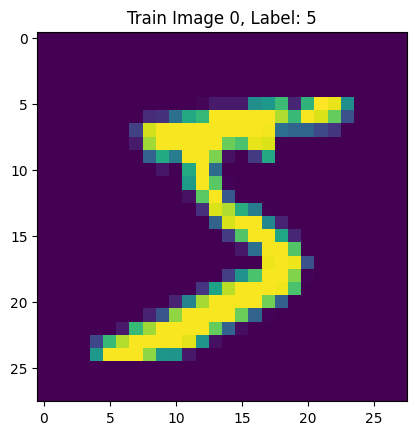

In [8]:
idx = 0
plt.imshow(train_images_raw[idx])
plt.title(f"Train Image {idx}, Label: {train_labels[idx]}")
plt.show()

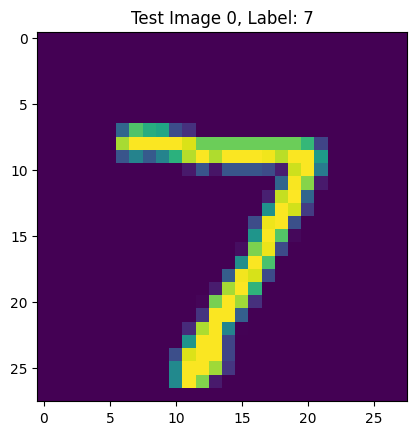

In [9]:
idx = 0
plt.imshow(test_images_raw[idx])
plt.title(f"Test Image {idx}, Label: {test_labels[idx]}")
plt.show()

## Modelling

Given a layer of inputs $\vec{a_{i}}$, a matrix of weights $\vec{W_i}$, biases $\vec{b_i}$ and an activation function $\sigma$, the inputs fed forward to $\vec{a_{i+1}}$ are as follows:
$$\sigma \left( \vec{W_i}\vec{a_{i}} + \vec{b_i} \right)=\vec{a_{i+1}}$$

Cost function, for all weights $\vec{w}$, and for actual outputs $a^{(L)}$ and real outputs $y_i$ (for one such $k$ such that $y_k=1$, and $y_j=0  \forall j \neq k$):
$$C(\vec{w})=\Sigma_{i} (a^{(L)}_i - y_i)^2$$

Need to compute gradient descent step on a batch of the training data at a time (e.g. 10)

$$
\frac{\delta C_0}{\delta w^{(L)}}=\frac{\delta z^{(L)}}{\delta w^{(L)}}\frac{\delta a^{(L)}}{\delta z^{(L)}}\frac{\delta C_0}{\delta a^{(L)}}=2(a^{(L)}-y)\sigma' (z^{(L)})a^{(L-1)}
$$

In [10]:
def sigmoid(x: np.array) -> np.array:
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x: np.array) -> np.array:
    return sigmoid(x) * (1 - sigmoid(x))

In [11]:
def label_one_hot_encoded(label: int) -> np.array:
    y = np.zeros(len(LABELS))
    y[label] = 1
    return y

def cost_function(predicted: np.array, actual: int) -> float:
    y = np.zeros(len(predicted))
    y[actual] = 1
    return sum((predicted - y)**2)

In [12]:
@dataclass
class Sample():
    image: np.array
    label: int


train = [Sample(image=train_images[i], label=train_labels[i]) for i in range(len(train_images))]

In [142]:
class Network:
    def __init__(self) -> None:
        self._l1_len = TOTAL_SIZE  # 784, input layer
        self._l2_len = 16  # hidden layer
        self._l3_len = len(LABELS)  # 10, final layer

        self._w1 = np.random.rand(self._l2_len, self._l1_len)

        bias_scale_factor = -36
        self._b1 = np.random.rand(self._l2_len) * bias_scale_factor

        self._w2 = np.random.rand(self._l3_len, self._l2_len)
        self._b2 = np.random.rand(self._l3_len)
    
    def predict(self, x: np.array) -> float:
        _, _, _, a2 = self.forward_propagation(x)
        return np.argmax(a2)
    
    def forward_propagation(self, x: np.array):
        # x is the flattened 28x28 matrix into an array of size 784
        z1 = np.matmul(self._w1, x) + self._b1
        a1 = sigmoid(z1)
        z2 = np.matmul(self._w2, a1) + self._b2
        a2 = sigmoid(z2)
        return z1, a1, z2, a2
    
    def train(self, samples: list[Sample]) -> None:
        batch_size = 100
        learning_rate = 0.5

        epochs = 25
        for epoch in range(epochs):
            LOGGER.debug(f"starting epoch {epoch}")
            random.shuffle(samples)
            batches = [samples[x:x+batch_size] for x in range(0, len(train), batch_size)]

            for _, batch in enumerate(batches):

                nabla_b2s = []
                nabla_w2s = []
                nabla_b1s = []
                nabla_w1s = []

                for sample in batch:
                    x = sample.image.flatten()

                    z1, a1, z2, a2 = self.forward_propagation(x)
                    delta2 = output_error(a2, label_one_hot_encoded(sample.label), z2)

                    nabla_b2 = delta2
                    nabla_w2 = np.outer(delta2, a1)

                    delta1 = np.matmul(self._w2.T, delta2) * sigmoid_deriv(z1)

                    nabla_b1 = delta1
                    nabla_w1 = np.outer(delta1, x)

                    nabla_b2s += [nabla_b2]
                    nabla_w2s += [nabla_w2]
                    nabla_b1s += [nabla_b1]
                    nabla_w1s += [nabla_w1]
                
                nabla_b1_batch = 1/len(batch) * sum(nabla_b1s)
                nabla_w1_batch = 1/len(batch) * sum(nabla_w1s)
                nabla_b2_batch = 1/len(batch) * sum(nabla_b2s)
                nabla_w2_batch = 1/len(batch) * sum(nabla_w2s)

                self._b1 = self._b1 - (learning_rate * nabla_b1_batch)
                self._w1 = self._w1 - (learning_rate * nabla_w1_batch)
                self._b2 = self._b2 - (learning_rate * nabla_b2_batch)
                self._w2 = self._w2 - (learning_rate * nabla_w2_batch)

def output_error(a: np.array, y: np.array, z: np.array):
    return 2 * sigmoid_deriv(z) * (a - y)

In [143]:
network = Network()
network.train(train)

2024-02-11 00:42:49 [debug    ] starting epoch 0              


2024-02-11 00:42:52 [debug    ] starting epoch 1              
2024-02-11 00:42:54 [debug    ] starting epoch 2              
2024-02-11 00:42:57 [debug    ] starting epoch 3              
2024-02-11 00:42:59 [debug    ] starting epoch 4              
2024-02-11 00:43:01 [debug    ] starting epoch 5              
2024-02-11 00:43:04 [debug    ] starting epoch 6              
2024-02-11 00:43:06 [debug    ] starting epoch 7              
2024-02-11 00:43:08 [debug    ] starting epoch 8              
2024-02-11 00:43:11 [debug    ] starting epoch 9              
2024-02-11 00:43:13 [debug    ] starting epoch 10             
2024-02-11 00:43:16 [debug    ] starting epoch 11             
2024-02-11 00:43:18 [debug    ] starting epoch 12             
2024-02-11 00:43:20 [debug    ] starting epoch 13             
2024-02-11 00:43:23 [debug    ] starting epoch 14             
2024-02-11 00:43:25 [debug    ] starting epoch 15             
2024-02-11 00:43:28 [debug    ] starting epoch 16      

In [144]:
from sklearn.metrics import accuracy_score
predictions = []

for x in test_images:
    result = network.predict(x.flatten())
    predictions += [result]

accuracy_score(test_labels, predictions)

0.5582